In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def multi_normal(x: np.ndarray, mu: np.ndarray, sigma: np.ndarray):
    exponent = -0.5 * (x - mu).T @ np.linalg.inv(sigma) @ (x - mu)
    denominator = np.sqrt((2 * np.pi) ** len(mu) * np.linalg.det(sigma))

    return np.exp(exponent) / denominator

In [3]:
def gmm(x: np.ndarray, phis: np.ndarray, mus: np.ndarray, covs: np.ndarray):
    K = len(phis)
    y = 0

    for k in range(K):
        phi, mu, cov = phis[k], mus[k], covs[k]
        y += phi * multi_normal(x, mu, cov)

    return y


def likelihood(xs: np.ndarray, phis: np.ndarray, mus: np.ndarray, covs: np.ndarray):
    eps = 1e-8
    L = 0
    N = len(xs)

    for x in xs:
        y = gmm(x, phis, mus, covs)
        L += np.log(y + eps)

    return L / N

In [4]:
data = np.loadtxt("./data/old_faithful.txt")
data.shape

(272, 2)

In [5]:
phis = np.array([0.5, 0.5])
mus = np.array([[0.0, 50.0], [0.0, 100.0]])
covs = np.array([np.eye(2), np.eye(2)])

K = len(phis)
N = len(data)
MAX_ITEMS = 100
THRESHOLD = 1e-4

In [6]:
current_likelihood = likelihood(data, phis, mus, covs)
print(f"Initial likelihood: {current_likelihood:.4f}")


for iter in range(MAX_ITEMS):
    qs = np.zeros((N, K))

    for n in range(N):
        x = data[n]

        for k in range(K):
            phi, mu, cov = phis[k], mus[k], covs[k]
            qs[n, k] = phi * multi_normal(x, mu, cov)

        qs[n] /= gmm(x, phis, mus, covs)

    qs_sum = qs.sum(axis=0)

    for k in range(K):
        phis[k] = qs_sum[k] / N

        c = 0
        for n in range(N):
            c += qs[n, k] * data[n]
        mus[k] = c / qs_sum[k]

        c = 0
        for n in range(N):
            z = data[n] - mus[k]
            z = z[:, np.newaxis]
            c += qs[n, k] * z @ z.T

        covs[k] = c / qs_sum[k]

    print(f"likelihood: {current_likelihood:.4f} at iteration {iter}")

    next_likelihood = likelihood(data, phis, mus, covs)

    diff = np.abs(next_likelihood - current_likelihood)

    if diff < THRESHOLD:
        print(f"Converged at iteration {iter}")
        break

    current_likelihood = next_likelihood

Initial likelihood: -16.5382
likelihood: -16.5382 at iteration 0
likelihood: -4.4155 at iteration 1
likelihood: -4.3570 at iteration 2
likelihood: -4.3023 at iteration 3
likelihood: -4.2453 at iteration 4
likelihood: -4.2001 at iteration 5
likelihood: -4.1642 at iteration 6
likelihood: -4.1557 at iteration 7
likelihood: -4.1554 at iteration 8
Converged at iteration 8


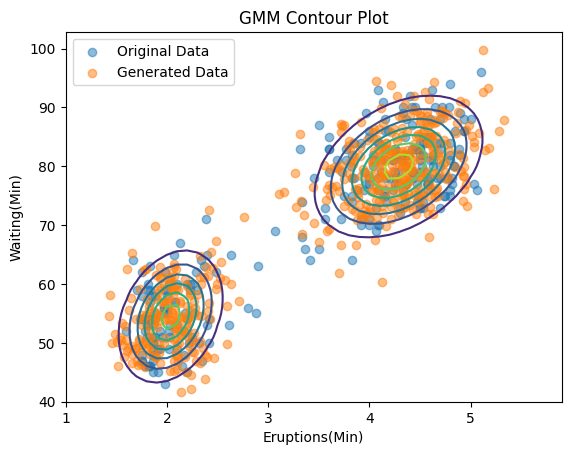

In [11]:
def plot_contour(w, mus, covs):
    x = np.arange(1, 6, 0.1)
    y = np.arange(40, 100, 1)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x = np.array([X[i, j], Y[i, j]])

            for k in range(len(mus)):
                mu, cov = mus[k], covs[k]
                Z[i, j] += w[k] * multi_normal(x, mu, cov)
    plt.contour(X, Y, Z)


N = 500
new_xs = np.zeros((N, 2))
for n in range(N):
    k = np.random.choice(len(phis), p=phis)
    mu, cov = mus[k], covs[k]
    new_xs[n] = np.random.multivariate_normal(mu, cov)

plt.scatter(data[:, 0], data[:, 1], alpha=0.5, label="Original Data")
plot_contour(phis, mus, covs)
plt.scatter(new_xs[:, 0], new_xs[:, 1], alpha=0.5, label="Generated Data")
plt.title("GMM Contour Plot")
plt.xlabel("Eruptions(Min)")
plt.ylabel("Waiting(Min)")
plt.legend()
plt.show()